# `hyve` : a constructive tutorial

In this notebook, we will illustrate the functionality of `hyve`, the `hypercoil` visualisation engine, in a tutorial. To do this, we will begin with the base core visualisation loop and, primitive by primitive, build up some different visualisations.

In addition to `hyve` and VTK, this tutorial requires the small `hyve-examples` library, which can be installed from `pip`.

Before running this notebook, you might wish to set the `OUTPUT_DIR` constant below to an existing directory where you have write access. For many systems, the default value (`/tmp`) will be fine.

In [1]:
import pyvista as pv
import templateflow.api as tflow
from IPython.display import SVG
from pathlib import Path
from PIL import Image

from hyve import (
    plotdef,
    parcellate_colormap,
    surf_from_archive,
    surf_scalars_from_cifti,
    surf_scalars_from_nifti,
    vertex_to_face,
    add_surface_overlay,
    plot_to_display,
    plot_to_image,
    save_figure,
    save_snapshots,
    text_element,
    Cell,
)
from hyve_examples import (
    get_null400_cifti,
    get_schaefer400_cifti,
    get_pain_thresh_nifti,
)

pv.set_jupyter_backend('client')
OUTPUT_DIR = '/tmp'

### Basics

The design of `hyve` differs from many visualisation libraries in that (i) it is a "visualisation engine" and (ii) it follows a compositional functional paradigm. In practice, what this means is that `hyve` shouldn't be used by calling a preprogrammed bank of plotting routines but instead by building up a new visualisation routine from functional atoms called *primitives*, and then calling the new routine we've constructed. The "central" function of `hyve` is thus not `plot` but `plotdef`. This tutorial takes a "constructive" approach in that it steps through the construction of new visualisation functions by adding one or two primitives at a time and addressing the challenges and technicalities that might arise.

We begin with by adding the `surf_from_archive` primitive to our visualisation definition by calling `hyve.plotdef` with the `surf_from_archive` transform queued. `surf_from_archive` loads a surface dataset from a remote archive, such as `templateflow`.

`hyve.plotdef` is a function whose arguments and return types are functions. It takes the sequence of parameterised transforms that it receives, and then applies them to `hyve`'s core visualisation loop to return a *transformed* visualisation loop. Each of the functions that it receives as arguments specify how the visualisation loop will be transformed. For the case of `surf_from_archive`, the transformed visualisation loop will now accept a new argument, `template`, which will specify the template whose surface representation should be loaded from the archive.

Let's try calling our new "visualisation" function, requesting the `fsLR` template from `templateflow`. When we call this minimal "visualisation", we immediately notice something isn't quite right. There is nothing to visualise! Instead, we get a data structure that contains a `pyvista.Plotter` and a metadata dictionary. (You'll see that, even though our visualisation only contains a surface geometry, the metadata dictionary has some default fields assigned for other geometries, like point clouds and networks.)

In [2]:
plot_f = plotdef(
    surf_from_archive(),
)
plot_f(
    template='fsLR',
    surf_projection='veryinflated',
)

{'plotter': ((<pyvista.plotting.plotter.Plotter at 0x7feaab7ba500>,
   {'hemisphere': 'both',
    'surfscalars': None,
    'projection': 'veryinflated',
    'pointsscalars': None,
    'nodecolor': 'black',
    'noderadius': 3.0,
    'nodealpha': 1.0,
    'edgecolor': 'edge_sgn',
    'edgeradius': 'edge_val',
    'edgealpha': 1.0,
    'elements': {}}),)}

Let's fix our (non-)visualisation by adding an output primitive. Let's say we want to create an interactive `pyvista` plot. For this, we'll use the `plot_to_display` primitive. Let's set our window size to be reasonably compact and try calling our newly transformed visualisation.

This time, you should be able to see an interactive rendering of two inflated cortical hemispheres. There will also be a menu that contains options like capturing a PNG screenshot or exporting an interactive HTML representation of the scene. (If you do not see the surface mesh, you might need to click the *Toggle rendering mode* menu button until local rendering is selected.)

In [3]:
plot_f = plotdef(
    surf_from_archive(),
    plot_to_display(),
)
plot_f(
    template='fsLR',
    surf_projection='veryinflated',
    window_size=(600, 500),
)

Widget(value="<iframe src='http://localhost:62385/index.html?ui=P_0x7feaab7f37f0_1&reconnect=auto' style='widt…

{}

### Input primitives

There's still no data here, only a geometry -- so we should change that! Let's add the 400-region Schaefer parcellation to the surface. `hyve_examples` has a convenience function that retrieves a CIfTI greyordinates dataset containing this parcellation, so we should modify our plot definition to load CIfTI data into a surface scalars dataset, using the `surf_scalars_from_cifti` primitive. (`hyve` has similar functions for loading data from NIfTI and GIfTI files, and in the near future will have a more generic primitive that calls the most appropriate subroutine after determining the data format.)

The `surf_scalars_from_cifti` primitive must be parameterised with a unique name for the surface scalar dataset. This design choice was made so that users would be able to pass multiple surface scalar datasets to the visualisation loop without ambiguity. The primitive transforms the visualisation loop to accept a new parameter based on the provided dataset name, in this case `parcellation_cifti`. Let's provide our new visualisation with the parcellation dataset from `hyve_examples`, and let's use a qualitative colour map from `matplotlib` with a dynamic range that spans all 400 parcels.

(Once again, you might wish to click the *Toggle rendering mode* button until local rendering is selected; this can substantially improve the quality of the rendered scene.)

**Note**: We've also toggled the `empty_builders` option to `True` below -- this is a temporary workaround to a notebook-specific issue that causes scalar bars to be plotted inline in the notebook.

In [4]:
plot_f = plotdef(
    surf_from_archive(),
    surf_scalars_from_cifti('parcellation'),
    plot_to_display(),
)
plot_f(
    template='fsLR',
    surf_projection='veryinflated',
    parcellation_cifti=get_schaefer400_cifti(),
    surf_scalars_cmap='tab20b',
    surf_scalars_clim=(1, 400),
    window_size=(600, 500),
    empty_builders=True,
)

/Users/rastkociric/Downloads/hyve/src/hyve/util.py:710: RuntimeWarning: invalid value encountered in true_divide
  (input[..., :3] / input[..., 3:], input[..., 3:]),


Widget(value="<iframe src='http://localhost:62385/index.html?ui=P_0x7feaab7f0430_1&reconnect=auto' style='widt…

{}

In the visualisation above, each parcel is assigned a colour from the qualitative `matplotlib` colour map, but the colours do not have any particular meaning. `hyve` also comes with two vertex-wise RGBA datasets in `fsLR` and `fsaverage` space, which are based on prior work. These datasets can be used to create parcel-wise colour maps that correspond approximately to these previous results. The `network` colour map will assign parcel colours inspired by the 7-network Yeo et al. 2011 parcellation, while the `modal` colour map will assign parcel colours inspired by the assessed regional modality from Glasser et al. 2016 (blue=visual, red=auditory, green=somatosensory).

We can transform the visualisation to use one of these colour maps by adding the `parcellate_colormap` primitive. This primitive is parameterised by three arguments: the first specifies the RGBA dataset to be used as a source for the colour map, the second specifies the scalar dataset to be parcellated, and the third specifies the template space for which the RGBA dataset should be retrieved. Note that we should no longer provide a `clim` argument to our visualisation function because `parcellate_colormap` handles this for us.

In the visualisation above, if we zoom in closely, we'll also notice some interpolation artefacts on the mesh surface. These occur because meshes are coloured according to their faces, but parcel data reside on vertices. The automatic interpolation applied by VTK isn't appropriate for a parcellated dataset. We can have our visualisation display a parcellation with sharper edges if we resample the data onto the faces using a nearest-neighbour strategy instead. Let's add the `vertex_to_face` primitive to our chain, instructing it to operate on the `parcellation` dataset and to colour each triangular face in the mesh based on the modal value among its three vertex neighbours.

Note that, at this point, the *order* in which primitives are composed becomes important. The parameterised `parcellate_colormap` primitive requires the presence of the `parcellation` scalars, so we must place it *after* `surf_scalars_from_nifti` in the compositional chain. How about `vertex_to_face`? The RGBA datasets provided with `hyve` are defined over vertices, so we can't apply them to a scalar dataset that is defined over faces. In other words, we must place the `parcellate_colormap` primitive *before* `vertex_to_face` in the chain.

In [5]:
plot_f = plotdef(
    surf_from_archive(),
    surf_scalars_from_cifti('parcellation'),
    parcellate_colormap('parcellation', 'network', template='fsLR'),
    vertex_to_face('parcellation', interpolation='mode'),
    plot_to_display(),
)
plot_f(
    template='fsLR',
    surf_projection='veryinflated',
    parcellation_cifti=get_schaefer400_cifti(),
    window_size=(600, 500),
    empty_builders=True,
)

Widget(value="<iframe src='http://localhost:62385/index.html?ui=P_0x7fea92fb0760_1&reconnect=auto' style='widt…

{'node_below_color': [0, 0, 0, 0]}

Now, suppose that we want to overlay another dataset on the parcellation. In particular, we would like to add a thresholded map of pain-related brain activity from a meta-analysis by Xu et al. to visualise how it compares with the parcellation. (Contrived? Yes, but it's a tutorial.) `hyve` supports this functionality, but we must wrap our existing surface scalar primitives in an *overlay* primitive first. We'll use the `add_surface_overlay` primitive. To do this, we move all of the primitives that will operate on the `parcellation` layer into the `add_surface_overlay` primitive, and also pass it the overlay name, `parcellation`, as a first argument.

Next, we create a second `add_surface_overlay` primitive for the thresholded map. We'll call this one `statmap`. Because our source dataset is a NIfTI, we should use the `surf_scalars_from_nifti` primitive here. The underlying geometric primitive that `hyve` uses to interpret scalar-valued datasets on surface meshes requires that all displayed datasets either be on faces or on vertices, so we will also need to push the `statmap` dataset onto faces to match the `parcellation` dataset. We'll use the `mean` interpolation strategy here because the data are continuous-valued.

To better highlight the statistical map layer, let's reduce the opacity of the parcellation. Let's also configure some visual properties of the `statmap` layer and set subthreshold values to be transparent using the `below_color` flag. (Note that when we use overlays, we should no longer use blanket geometric arguments like `surf_scalars_alpha` or `surf_scalars_cmap` -- we should instead use the overlay-specific `parcellation_alpha` or `statmap_cmap`.)

In [6]:
plot_f = plotdef(
    surf_from_archive(),
    add_surface_overlay(
        'parcellation',
        surf_scalars_from_cifti('parcellation'),
        parcellate_colormap('parcellation', 'network', template='fsLR'),
        vertex_to_face('parcellation', interpolation='mode'),
    ),
    add_surface_overlay(
        'statmap',
        surf_scalars_from_nifti('statmap', template='fsLR'),
        vertex_to_face('statmap', interpolation='mean'),
    ),
    plot_to_display(),
)
plot_f(
    template='fsLR',
    surf_projection='veryinflated',
    parcellation_cifti=get_schaefer400_cifti(),
    parcellation_alpha=0.3,
    statmap_nifti=get_pain_thresh_nifti(),
    statmap_cmap='inferno',
    statmap_clim=(0.3, 8),
    statmap_alpha=0.9,
    statmap_below_color=(0, 0, 0, 0),
    window_size=(600, 500),
    empty_builders=True,
)

Widget(value="<iframe src='http://localhost:62385/index.html?ui=P_0x7fea92fb3760_1&reconnect=auto' style='widt…

{'parcellation_cmap': None,
 'parcellation_clim': None,
 'parcellation_cmap_negative': None,
 'parcellation_clim_negative': None,
 'parcellation_color': None,
 'parcellation_alpha': 0.3,
 'parcellation_below_color': None,
 'parcellation_scalar_bar_style': <factory>,
 'parcellation_blend_mode': 'source_over',
 'node_below_color': [0, 0, 0, 0],
 'statmap_cmap': 'inferno',
 'statmap_clim': (0.3, 8),
 'statmap_cmap_negative': None,
 'statmap_clim_negative': None,
 'statmap_color': None,
 'statmap_alpha': 0.9,
 'statmap_below_color': (0, 0, 0, 0),
 'statmap_scalar_bar_style': <factory>,
 'statmap_blend_mode': 'source_over'}

Before we move on to output and geometric primitives, let's briefly examine the visualisation we've created. As we've seen, the visualisation is a composite function created through progressive transformation of `hyve`'s core visualisation loop. This function is returned as `plot_f` above. For any such visualisation function that we define using `plotdef`, `hyve` automatically constructs a signature and documentation string. We can read these by calling `help` on the function.

(Some parameter descriptors might still be missing.)

In [7]:
help(plot_f)

Help on function h in module conveyant.containers:

h(*, load_mask: bool = True, surf_projection: Optional[Sequence[str]] = ('veryinflated',), template: str = 'fsLR', parcellation_cifti: Union[nibabel.cifti2.cifti2.Cifti2Image, str], parcellation_cmap: Optional[Any] = None, parcellation_clim: Optional[Tuple[float, float]] = None, parcellation_cmap_negative: Optional[Any] = None, parcellation_clim_negative: Optional[Tuple[float, float]] = None, parcellation_color: Optional[Any] = None, parcellation_alpha: float = 1.0, parcellation_below_color: Optional[Any] = None, parcellation_scalar_bar_style: Optional[Mapping[str, Any]] = <factory>, parcellation_blend_mode: Literal['source_over'] = 'source_over', surf_scalars: Sequence[str] = (), statmap_nifti: Union[nibabel.nifti1.Nifti1Image, str], statmap_cmap: Optional[Any] = None, statmap_clim: Optional[Tuple[float, float]] = None, statmap_cmap_negative: Optional[Any] = None, statmap_clim_negative: Optional[Tuple[float, float]] = None, statmap_c

We can also use the same visualisation to plot a new scene. Below, we replace the Schaefer parcellation with a 400-region spatial null parcellation created by ablating a differentiable program. We replace the thresholded pain map with a grey matter density map from `templateflow`, and we change some of the visual properties of the plotted datasets.

In [8]:
plot_f(
    template='fsLR',
    surf_projection='veryinflated',
    parcellation_cifti=get_null400_cifti(),
    parcellation_alpha=0.8,
    parcellation_cmap='modal',
    statmap_nifti=tflow.get(
        template='MNI152NLin2009cAsym',
        suffix='probseg',
        label='GM',
        resolution=2
    ),
    statmap_cmap='bone',
    statmap_clim=(0.5, 1.0),
    statmap_alpha=0.6,
    statmap_below_color=(0, 0, 0, 0),
    window_size=(600, 500),
    empty_builders=True,
)

Widget(value="<iframe src='http://localhost:62385/index.html?ui=P_0x7feaa5505c90_1&reconnect=auto' style='widt…

{'parcellation_cmap': 'modal',
 'parcellation_clim': None,
 'parcellation_cmap_negative': None,
 'parcellation_clim_negative': None,
 'parcellation_color': None,
 'parcellation_alpha': 0.8,
 'parcellation_below_color': None,
 'parcellation_scalar_bar_style': <factory>,
 'parcellation_blend_mode': 'source_over',
 'node_below_color': [0, 0, 0, 0],
 'statmap_cmap': 'bone',
 'statmap_clim': (0.5, 1.0),
 'statmap_cmap_negative': None,
 'statmap_clim_negative': None,
 'statmap_color': None,
 'statmap_alpha': 0.6,
 'statmap_below_color': (0, 0, 0, 0),
 'statmap_scalar_bar_style': <factory>,
 'statmap_blend_mode': 'source_over'}

### Output primitives

What if, instead of an interactive scene, we would like to create a persistent, static figure? In this case, we'll use `plot_to_image` instead of `plot_to_display`. `plot_to_image` only captures snapshots from the plotter -- this is so they can be saved downstream either as individual snapshots or laid out into a figure. Let's keep things simple for now and add the `save_snapshots` primitive to save each snapshot individually.

`save_snapshots` is parameterised with the `fname_spec` argument. `fname_spec` is a string that optionally contains braced format fields. The format fields can contain any metadata keys, and they will be populated with the corresponding metadata values when each snapshot file is written. In addition to the metadata fields we previously saw, `plot_to_image` has also transformed the core visualisation loop to add a `view` field to the metadata (and `views` as an argument to `plot_f`). Because we are now capturing static snapshots of scenes, we can specify the views that each snapshot should capture. By default, `hyve` will capture the six orthogonal views on each scene; these will be named `dorsal`, `ventral`, `anterior`, `posterior`, and either `left` and `right` when both hemispheres are plotted or `lateral` and `medial` when a single hemisphere is plotted. Let's keep the default settings for now.

Our new visualiser will also require the `output_dir` argument, which specifies where it will save the snapshots that it captures.

(Note that we use the `%%capture` directive to suppress the plotter in the notebook. This shouldn't be done outside of the notebook context.)

In [9]:
%%capture
pv.set_jupyter_backend('trame')

plot_f = plotdef(
    surf_from_archive(),
    add_surface_overlay(
        'parcellation',
        surf_scalars_from_cifti('parcellation'),
        parcellate_colormap('parcellation', 'modal', template='fsLR'),
        vertex_to_face('parcellation', interpolation='mode'),
    ),
    add_surface_overlay(
        'statmap',
        surf_scalars_from_nifti('statmap', template='fsLR'),
        vertex_to_face('statmap', interpolation='mean'),
    ),
    plot_to_image(),
    save_snapshots(
        fname_spec=(
            'scalars-{surfscalars}_hemisphere-{hemisphere}_view-{view}'
        ),
    ),
)
plot_f(
    template='fsLR',
    surf_projection='veryinflated',
    parcellation_cifti=get_schaefer400_cifti(),
    parcellation_alpha=0.3,
    statmap_nifti=get_pain_thresh_nifti(),
    statmap_cmap='inferno',
    statmap_clim=(0.3, 8),
    statmap_alpha=0.9,
    statmap_below_color=(0, 0, 0, 0),
    output_dir=OUTPUT_DIR,
    window_size=(600, 500),
    empty_builders=True,
)

Let's see where `hyve` saved the snapshots, and then display one of the captured images. We can see that the paths to the snapshots follow the naming specification we provided above.

/tmp/scalars-parcellation+statmap_hemisphere-both_view-ventral_scene.png
/tmp/scalars-parcellation+statmap_hemisphere-both_view-dorsal_scene.png
/tmp/scalars-parcellation+statmap_hemisphere-both_view-left_scene.png
/tmp/scalars-parcellation+statmap_hemisphere-both_view-posterior_scene.png
/tmp/scalars-parcellation+statmap_hemisphere-both_view-anterior_scene.png
/tmp/scalars-parcellation+statmap_hemisphere-both_view-right_scene.png


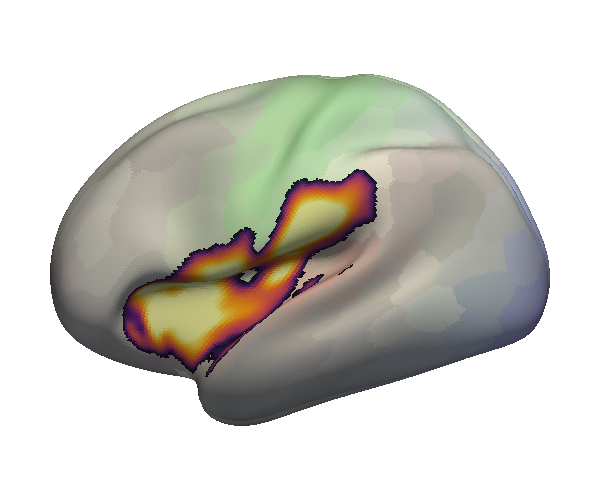

In [10]:
paths = tuple(
    Path(OUTPUT_DIR).glob(
        'scalars-parcellation+statmap_hemisphere-both_view-*.png'
    )
)
for path in paths:
    print(path)
display(
    Image.open(Path(OUTPUT_DIR) / (
        'scalars-parcellation+statmap_hemisphere-both_view-left_scene.png'
    ))
)

This is a good start, but we can do better. In particular, all the views we captured were of the same scene, a cortical surface that contains both hemispheres. Unfortunately, these views all obstruct the brain's medial surface. To view medial data, we don't need a new visualisation -- we just need to make use of the `hemisphere` and `views` arguments, and the argument mapping protocol of the `hyve` core loop will handle the rest.

For the `hemisphere` argument, we still want to get some views that contain both hemispheres -- in particular, the dorsal, ventral, anterior, and posterior views benefit from having both hemispheres plotted together. We will add to these the lateral and medial views from each of the left and right hemispheres. By convention, `hyve` plots both hemispheres when it does not receive any `hemisphere` value (`hemisphere=None` by default). So our assignment sequence for `hemisphere` should include all three of `left`, `right`, and `None` -- and `hyve` will then call the plotter once for each specified argument value.

For `views`, `hyve` accepts a special conditioning syntax that circumvents the usual conventions of the mapper protocol. It's possible to set the views using a dictionary whose keys are hemispheres and whose values are sequences of the views to be captured for each hemisphere. Let's run our visualisation with the updated arguments.

(*Technical detail:* this special syntax is actually used because `views` is not an argument to the core visualisation loop, but to a *postprocessor* function that is passed to the core visualisation loop. But this detail is likely unimportant!)

(*Note*: We could have placed `left` and `right` under `both` instead of `lateral` under `left` and `right`, and we would have received visually indistinguishable results.)

In [11]:
%%capture
plot_f(
    template='fsLR',
    surf_projection='veryinflated',
    parcellation_cifti=get_schaefer400_cifti(),
    parcellation_alpha=0.3,
    statmap_nifti=get_pain_thresh_nifti(),
    statmap_cmap='inferno',
    statmap_clim=(0.3, 8),
    statmap_alpha=0.9,
    statmap_below_color=(0, 0, 0, 0),
    output_dir=OUTPUT_DIR,
    window_size=(600, 500),
    hemisphere=['left', 'right', 'both'],
    views={
        'left': ('medial', 'lateral'),
        'right': ('medial', 'lateral'),
        'both': ('dorsal', 'ventral', 'anterior', 'posterior'),
    },
    empty_builders=True,
)

And let's inspect one of those medial views now.

/tmp/scalars-parcellation+statmap_hemisphere-both_view-ventral_scene.png
/tmp/scalars-parcellation+statmap_hemisphere-both_view-dorsal_scene.png
/tmp/scalars-parcellation+statmap_hemisphere-both_view-left_scene.png
/tmp/scalars-parcellation+statmap_hemisphere-right_view-medial_scene.png
/tmp/scalars-parcellation+statmap_hemisphere-both_view-posterior_scene.png
/tmp/scalars-parcellation+statmap_hemisphere-right_view-lateral_scene.png
/tmp/scalars-parcellation+statmap_hemisphere-both_view-anterior_scene.png
/tmp/scalars-parcellation+statmap_hemisphere-both_view-right_scene.png
/tmp/scalars-parcellation+statmap_hemisphere-left_view-medial_scene.png
/tmp/scalars-parcellation+statmap_hemisphere-left_view-lateral_scene.png


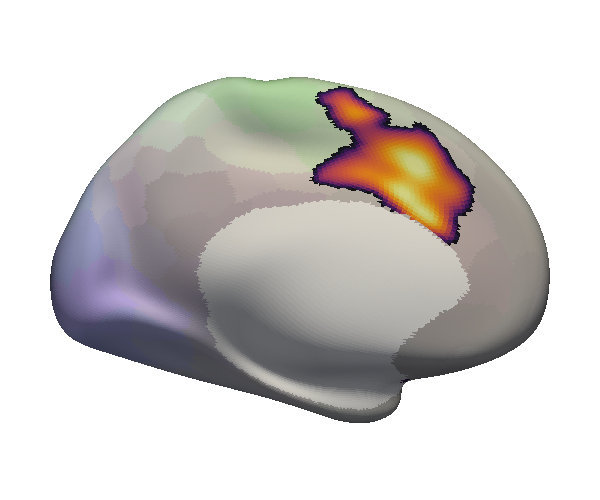

In [12]:
paths = tuple(
    Path(OUTPUT_DIR).glob(
        'scalars-parcellation+statmap_hemisphere-*_view-*.png'
    )
)
for path in paths:
    print(path)
display(
    Image.open(Path(OUTPUT_DIR) / (
        'scalars-parcellation+statmap_hemisphere-left_view-medial_scene.png'
    ))
)

Now, instead of just having a visualisation that emits separate snapshots of different scenes, let's transform the loop to create a figure. For this, we're going to need to use the layout system to create and annotate the layout taht we want for the figure.

The full set of layout builder operations allows for some elaborate layout configurations and is documented elsewhere, but for our purposes we'll only need a simple grid. We create the grid by first concatenating three cells in a column, with each cell occupying a third of the layout, and then concatenating three copies of the column together in a row, with each column occupying a third of the resulting layout.

Next, we can annotate the layout cells to semantically specify the content of each. The layout we've created is in column-major order, so we should keep this in mind when annotating. Annotations essentially provide instructions to `hyve`'s figure builder to route snapshots and other graphical elements to specific cells in the layout. Let's build a "panoptic spread" figure that shows all views on the brain in different panels. We can place views on the left hemisphere on the left side of the figure (column 1, cells 0 and 1 and 2) and views on the right hemisphere on the right side of the figure (column 3, cells 6 and 7 and 8).

We also place a special annotation in the centre cell, the `elements=['title', 'scalar_bar']` annotation, instructing the figure builder to include non-snapshot graphical elements whose names are `'title'` and `'scalar_bar'` in that cell. We'll add those elements in the plot definition.

In [13]:
layout = Cell() / Cell() / Cell() << (1 / 3)
layout = layout | layout | layout << (1 / 3)
annotations = {
    0: dict(
        hemisphere='left',
        view='lateral',
    ),
    1: dict(view='dorsal'),
    2: dict(
        hemisphere='left',
        view='medial',
    ),
    3: dict(view='anterior'),
    4: dict(elements=['title', 'scalar_bar']),
    5: dict(view='posterior'),
    6: dict(
        hemisphere='right',
        view='lateral',
    ),
    7: dict(view='ventral'),
    8: dict(
        hemisphere='right',
        view='medial',
    ),
}
layout = layout.annotate(annotations)

print(layout)

AnnotatedLayout(layout=CellLayout(left=CellLayout(left=Cell(loc=None, dim=None), right=CellLayout(left=Cell(loc=None, dim=None), right=Cell(loc=None, dim=None), orientation=h, position=0.49999999999999994), orientation=h, position=0.3333333333333333), right=CellLayout(left=CellLayout(left=Cell(loc=None, dim=None), right=CellLayout(left=Cell(loc=None, dim=None), right=Cell(loc=None, dim=None), orientation=h, position=0.49999999999999994), orientation=h, position=0.3333333333333333), right=CellLayout(left=Cell(loc=None, dim=None), right=CellLayout(left=Cell(loc=None, dim=None), right=Cell(loc=None, dim=None), orientation=h, position=0.49999999999999994), orientation=h, position=0.3333333333333333), orientation=v, position=0.49999999999999994), orientation=v, position=0.3333333333333333), annotations={0: {'hemisphere': 'left', 'view': 'lateral'}, 1: {'view': 'dorsal'}, 2: {'hemisphere': 'left', 'view': 'medial'}, 3: {'view': 'anterior'}, 4: {'elements': ['title', 'scalar_bar']}, 5: {'view

We now modify our visualisation function to use the `save_figure` primitive instead of `save_snapshots`. This transforms the visualisation loop to pass its results to the figure builder routine. We parameterise `save_figure` using the layout that we created, and also configuring the canvas dimensions and colour. Note that we can no longer use the `hemisphere` or `view` fields in our filename specification because the values of those fields are not consistent for all scene representations that we are including in the figure (i.e., there are 6 different `view` values and three different `hemisphere` values in the data). We are still able to use `surfscalars`, however, since the same surface scalar dataset is present in all scene representations.

We also want to add a title to our plot. For this, we include the `text_element` primitive. The name we provide (`'title'`) must match the string we included in the `elements` field of out layout annotation. The content specifies the text itself and can include valid metadata fields. The remainder of the parameters configure the visual properties of the element. (A future version of `hyve` should splice these parameters onto the visualisation function returned by `plotdef` in forms like `title_content`, `title_font`, etc.)

Let's create our figure now.

In [14]:
%%capture

plot_f = plotdef(
    surf_from_archive(),
    add_surface_overlay(
        'parcellation',
        surf_scalars_from_cifti('parcellation'),
        parcellate_colormap('parcellation', 'modal', template='fsLR'),
        vertex_to_face('parcellation', interpolation='mode'),
    ),
    add_surface_overlay(
        'statmap',
        surf_scalars_from_nifti('statmap', template='fsLR'),
        vertex_to_face('statmap', interpolation='mean'),
    ),
    text_element(
        name='title',
        content='{surfscalars}',
        bounding_box_height=192,
        font_size_multiplier=0.75,
        font_color='#cccccc',
        priority=-1,
    ),
    plot_to_image(),
    save_figure(
        layout_kernel=layout,
        canvas_size=(900, 750),
        canvas_color=(0, 0, 0),
        fname_spec='scalars-{surfscalars}',
        scalar_bar_action='collect',
    ),
)
plot_f(
    template='fsLR',
    surf_projection='veryinflated',
    parcellation_cifti=get_schaefer400_cifti(),
    parcellation_alpha=0.3,
    parcellation_scalar_bar_style={
        'name': 'parcel',
        'orientation': 'h',
    },
    statmap_nifti=get_pain_thresh_nifti(),
    statmap_cmap='inferno',
    statmap_clim=(0.3, 8),
    statmap_alpha=0.9,
    statmap_below_color=(0, 0, 0, 0),
    statmap_scalar_bar_style={
        'name': 'zstat',
        'orientation': 'h',
    },
    output_dir=OUTPUT_DIR,
    window_size=(600, 500),
    hemisphere=['left', 'right', 'both'],
    views={
        'left': ('medial', 'lateral'),
        'right': ('medial', 'lateral'),
        'both': ('dorsal', 'ventral', 'anterior', 'posterior'),
    },
    theme=pv.themes.DarkTheme(),
)

And let's display it below.

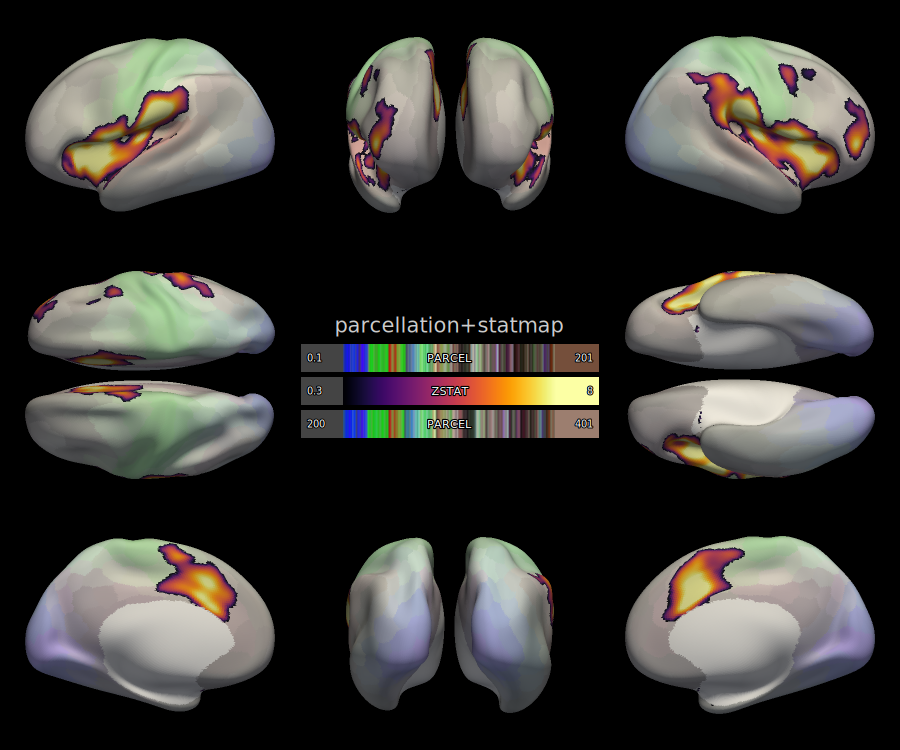

In [15]:
display(SVG(
    Path(OUTPUT_DIR) / 'scalars-parcellation+statmap_scene.svg'
))

### Geometric primitives

Beyond the surface datasets explored above, `hyve` supports plotting data associated with additional geometries.

 . . . to be continued . . .

In [16]:
import numpy as np
import pandas as pd

from hyve_examples import (
    get_schaefer400_synthetic_conmat,
    get_schaefer400_cifti,
)
from hyve.flows import plotdef
from hyve.flows import add_network_data
from hyve.transforms import (
    surf_from_archive,
    surf_scalars_from_cifti,
    parcellate_colormap,
    add_node_variable,
    add_edge_variable,
    plot_to_image,
    save_snapshots,
    node_coor_from_parcels,
    build_network,
    add_network_overlay,
)
pv.set_jupyter_backend('client')

# Get a parcellation and the corresponding connectivity matrix
parcellation = get_schaefer400_cifti()
cov = pd.read_csv(
    get_schaefer400_synthetic_conmat(), sep='\t', header=None
).values

# Select some nodes and edges to be highlighted
vis_nodes_edge_selection = np.zeros(400, dtype=bool)
vis_nodes_edge_selection[0:5] = True
vis_nodes_edge_selection[200:205] = True

# Define a plotting function
plot_f = plotdef(
    surf_from_archive(),
    surf_scalars_from_cifti('parcellation', plot=False),
    add_network_data(
        add_node_variable('vis'),
        add_edge_variable(
            'vis_conn',
            threshold=10,
            topk_threshold_nodewise=True,
            absolute=True,
            incident_node_selection=vis_nodes_edge_selection,
            emit_degree=True,
        ),
        add_edge_variable(
            'vis_internal_conn',
            absolute=True,
            connected_node_selection=vis_nodes_edge_selection,
        ),
    ),
    node_coor_from_parcels('parcellation'),
    build_network('vis'),
    parcellate_colormap('parcellation', 'network', target='node'),
    plot_to_display(),
)

# Generate a plot
plot_f(
    template='fsLR',
    surf_projection='inflated',
    surf_alpha=0.2,
    parcellation_cifti=parcellation,
    node_radius='vis_conn_degree',
    node_color='index',
    edge_color='vis_conn_sgn',
    edge_radius='vis_conn_val',
    vis_nodal=vis_nodes_edge_selection.astype(int),
    vis_conn_adjacency=cov,
    vis_internal_conn_adjacency=cov,
    window_size=(600, 500),
    empty_builders=True,
);

Widget(value="<iframe src='http://localhost:62385/index.html?ui=P_0x7fea7088c6d0_4&reconnect=auto' style='widt…

In [17]:
import numpy as np
import pandas as pd

from hyve_examples import (
    get_schaefer400_synthetic_conmat,
    get_schaefer400_cifti,
)
from hyve.flows import plotdef
from hyve.flows import add_network_data
from hyve.transforms import (
    surf_from_archive,
    surf_scalars_from_cifti,
    parcellate_colormap,
    add_node_variable,
    add_edge_variable,
    plot_to_image,
    save_snapshots,
    node_coor_from_parcels,
    build_network,
    add_network_overlay,
)

parcellation = get_schaefer400_cifti()
cov = pd.read_csv(
    get_schaefer400_synthetic_conmat(), sep='\t', header=None
).values

vis_nodes_edge_selection = np.zeros(400, dtype=bool)
vis_nodes_edge_selection[0:2] = True
vis_nodes_edge_selection[200:202] = True

plot_f = plotdef(
    surf_from_archive(),
    surf_scalars_from_cifti('parcellation', plot=False),
    #build_network('vis'),
    add_network_overlay(
        'vis',
        add_network_data(
            add_edge_variable(
                "vis_conn",
                absolute=True,
                incident_node_selection=vis_nodes_edge_selection,
            ),
            add_edge_variable(
                "vis_internal_conn",
                absolute=True,
                connected_node_selection=vis_nodes_edge_selection,
                emit_degree=True,
                emit_incident_nodes=(0.2, 1),
                removed_val=0.03,
                surviving_val=1.0,
            ),
            how='left',
        ),
        node_coor_from_parcels('parcellation'),
        parcellate_colormap('parcellation', 'modal', target='node'),
    ),
    plot_to_display(),
)
plot_f(
    template="fsLR",
    surf_projection='veryinflated',
    surf_alpha=0.2,
    parcellation_cifti=parcellation,
    vis_conn_adjacency=cov,
    vis_internal_conn_adjacency=cov,
    vis_node_radius='vis_internal_conn_degree',
    vis_node_color='index',
    vis_node_alpha='vis_internal_conn_incidents',
    vis_edge_color='vis_conn_sgn',
    vis_edge_radius='vis_conn_val',
    vis_edge_alpha='vis_internal_conn_val',
    window_size=(600, 500),
    empty_builders=True,
);

Widget(value="<iframe src='http://localhost:62385/index.html?ui=P_0x7feaab7b8550_4&reconnect=auto' style='widt…

In [18]:
from hyve.transforms import (
    points_scalars_from_nifti,
)


plot_f = plotdef(
    surf_from_archive(),
    points_scalars_from_nifti('pain'),
    plot_to_display(),
)
plot_f(
    template='fsaverage',
    surf_projection=('pial',),
    surf_alpha=0.3,
    pain_nifti=get_pain_thresh_nifti(),
    points_scalars_cmap='magma',
    window_size=(600, 500),
    empty_builders=True,
)

Widget(value="<iframe src='http://localhost:62385/index.html?ui=P_0x7fea90a88550_4&reconnect=auto' style='widt…

{}